Hypothesis 3: "Increases in average hourly earnings (AHEMAN) lead to an increase in inflation (CPI)."

Rationale: If wages increase, people have more disposable income, which can drive up demand and prices, contributing to inflation.


In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project='fred-employment-initial-test')

# Your query string
query = """
SELECT *
FROM `fred-employment-initial-test.fred_data.fred_data_withnotes`
WHERE series_id IN ('AHEMAN')
"""

# Run the query
query_job = client.query(query)

# Convert the query results to a pandas DataFrame
data = query_job.to_dataframe()

# Display the first few rows
print(data.head())

                       date series_id  value  \
0 1939-01-01 00:00:00+00:00    AHEMAN   0.49   
1 1939-02-01 00:00:00+00:00    AHEMAN   0.49   
2 1939-03-01 00:00:00+00:00    AHEMAN   0.49   
3 1939-04-01 00:00:00+00:00    AHEMAN   0.49   
4 1939-05-01 00:00:00+00:00    AHEMAN   0.49   

                                               title             units  \
0  Average Hourly Earnings of Production and Nons...  Dollars per Hour   
1  Average Hourly Earnings of Production and Nons...  Dollars per Hour   
2  Average Hourly Earnings of Production and Nons...  Dollars per Hour   
3  Average Hourly Earnings of Production and Nons...  Dollars per Hour   
4  Average Hourly Earnings of Production and Nons...  Dollars per Hour   

  frequency      seasonal_adjustment            last_updated  \
0   Monthly  Not Seasonally Adjusted  2024-08-02 07:47:15-05   
1   Monthly  Not Seasonally Adjusted  2024-08-02 07:47:15-05   
2   Monthly  Not Seasonally Adjusted  2024-08-02 07:47:15-05   
3   Monthl

**PULLING CPI FROM FRED**

In [ ]:
import pandas_datareader.data as web
from datetime import datetime

# Set the date range
start = datetime(1939, 1, 1)
end = datetime(2024, 1, 1)

# Fetch CPI data from FRED
cpi_data = web.DataReader('CPIAUCSL', 'fred', start, end)

# Display the first few rows to verify
print(cpi_data.head())

            CPIAUCSL
DATE                
1947-01-01     21.48
1947-02-01     21.62
1947-03-01     22.00
1947-04-01     22.00
1947-05-01     21.95


**Merging AHEMAN data with CPIAUSCL**

In [ ]:
import pandas as pd

# Remove timezone information from the date columns
cpi_data['DATE'] = pd.to_datetime(cpi_data['DATE']).dt.tz_localize(None)
data['date'] = pd.to_datetime(data['date']).dt.tz_localize(None)

# Now you can merge the dataframes on the 'date' column
merged_data = pd.merge(data, cpi_data, left_on='date', right_on='DATE', suffixes=('_AHEMAN', '_CPIAUCSL'))

# Display the merged data
print(merged_data.head())


        date series_id  value  \
0 1947-01-01    AHEMAN   1.03   
1 1947-02-01    AHEMAN   1.04   
2 1947-03-01    AHEMAN   1.06   
3 1947-04-01    AHEMAN   1.06   
4 1947-05-01    AHEMAN   1.08   

                                               title             units  \
0  Average Hourly Earnings of Production and Nons...  Dollars per Hour   
1  Average Hourly Earnings of Production and Nons...  Dollars per Hour   
2  Average Hourly Earnings of Production and Nons...  Dollars per Hour   
3  Average Hourly Earnings of Production and Nons...  Dollars per Hour   
4  Average Hourly Earnings of Production and Nons...  Dollars per Hour   

  frequency      seasonal_adjustment            last_updated  \
0   Monthly  Not Seasonally Adjusted  2024-08-02 07:47:15-05   
1   Monthly  Not Seasonally Adjusted  2024-08-02 07:47:15-05   
2   Monthly  Not Seasonally Adjusted  2024-08-02 07:47:15-05   
3   Monthly  Not Seasonally Adjusted  2024-08-02 07:47:15-05   
4   Monthly  Not Seasonally Adjusted

**DUAL-AXIS LINE GRAPH:**

In [ ]:
print(merged_data.columns)

Index(['date', 'series_id', 'value', 'title', 'units', 'frequency',
       'seasonal_adjustment', 'last_updated', 'notes', 'index', 'DATE',
       'CPIAUCSL'],
      dtype='object')


In [ ]:
!pip install mplcyberpunk

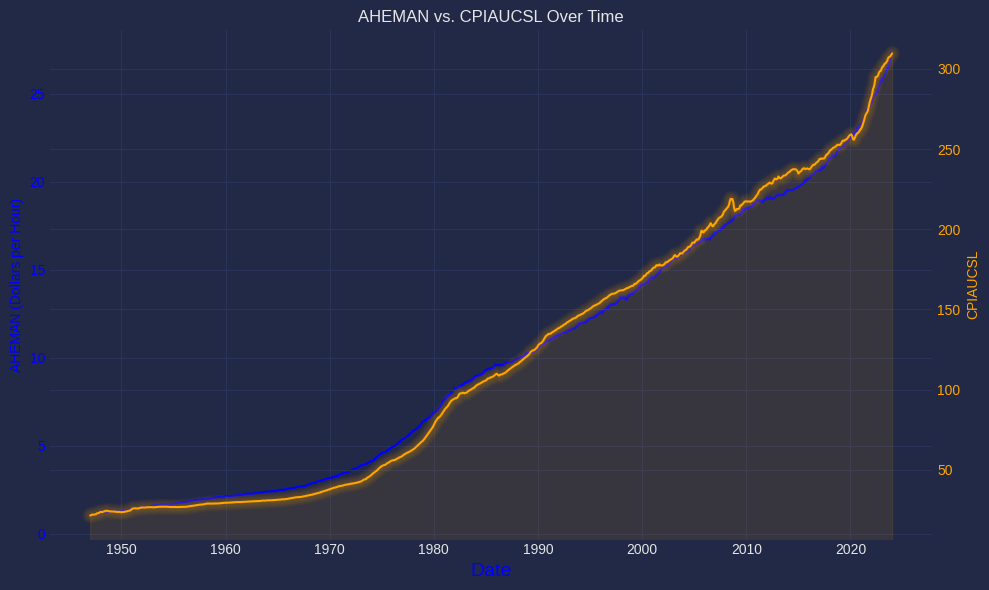

In [ ]:
import matplotlib.pyplot as plt
import mplcyberpunk

# Plotting the data with Cyberpunk theme
plt.style.use("cyberpunk")

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot AHEMAN data on the first axis
ax1.plot(merged_data['date'], merged_data['value'], color='blue', label='AHEMAN')
ax1.set_xlabel('Date', fontsize=14, color='blue')
ax1.set_ylabel('AHEMAN (Dollars per Hour)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for CPIAUCSL (CPI data)
ax2 = ax1.twinx()
ax2.plot(merged_data['date'], merged_data['CPIAUCSL'], color='orange', label='CPIAUCSL')
ax2.set_ylabel('CPIAUCSL', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Set the title and show the plot with cyberpunk effects
plt.title('AHEMAN vs. CPIAUCSL Over Time')
mplcyberpunk.add_glow_effects()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

The line graph shows how closely AHEMAN (Average Hourly Earnings of Production and Nonsupervisory Employees) tracks with CPIAUCSL (Consumer Price Index for All Urban Consumers) over time. The two series appear to move in tandem, suggesting a strong relationship between wage growth and inflation.

In [ ]:
print(merged_data.columns)

Index(['date', 'series_id', 'value', 'title', 'units', 'frequency',
       'seasonal_adjustment', 'last_updated', 'notes', 'index', 'DATE',
       'CPIAUCSL'],
      dtype='object')


In [ ]:
# Calculate the Pearson correlation coefficient
correlation = merged_data['value'].corr(merged_data['CPIAUCSL'])
print(f'Pearson Correlation Coefficient: {correlation}')

Pearson Correlation Coefficient: 0.99874692409839


**Linear Regression:**

In [ ]:
import statsmodels.api as sm

# Define the independent and dependent variables
X = merged_data['value']  # Independent variable (Average Hourly Earnings)
y = merged_data['CPIAUCSL']  # Dependent variable (Consumer Price Index)

# Add a constant to the independent variable
X = sm.add_constant(X)

# Run the OLS regression
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCSL   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 3.676e+05
Date:                Mon, 09 Sep 2024   Prob (F-statistic):               0.00
Time:                        23:24:11   Log-Likelihood:                -2651.5
No. Observations:                 925   AIC:                             5307.
Df Residuals:                     923   BIC:                             5317.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0394      0.236     17.117      0.0

**R-squared** = 0.997: This indicates that 99.7% of the variance in CPIAUCSL is explained by AHEMAN. This is an extremely high level of correlation between the two variables.

**Coefficient for AHEMAN** = 11.5488: For every dollar increase in average hourly earnings, CPI is predicted to increase by approximately 11.55 units. This suggests a strong positive relationship between wage growth and inflation (as measured by CPI).

**P-value for AHEMAN** = 0.000: The p-value for AHEMAN is extremely low, indicating that the relationship between AHEMAN and CPIAUCSL is statistically significant.

**F-statistic = 3.676e+05**: The model has a very high F-statistic, which reinforces the strong statistical significance of the relationship.

**SCATTER PLOT:**

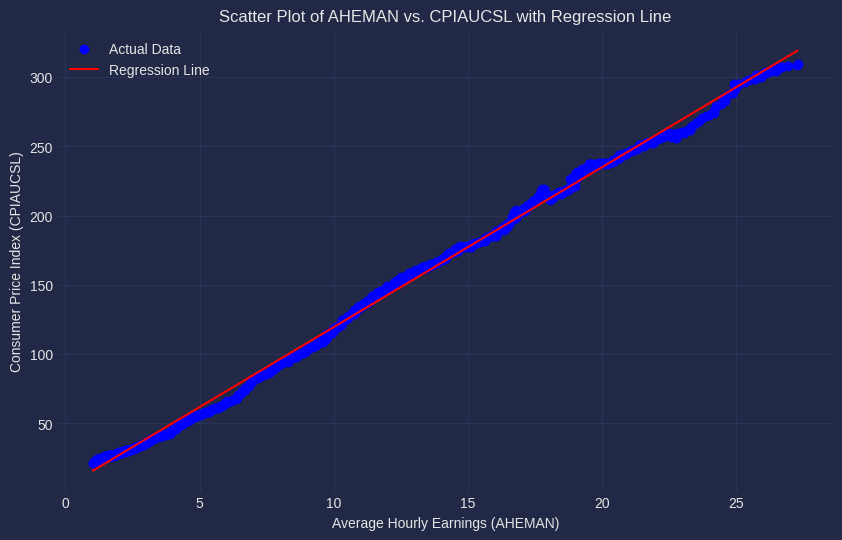

In [ ]:
# Generate predictions
y_pred = model.predict(X)

# Plot the data points and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['value'], merged_data['CPIAUCSL'], color='blue', label='Actual Data')  # Replace 'AHEMAN' with 'value'
plt.plot(merged_data['value'], y_pred, color='red', label='Regression Line')  # Replace 'AHEMAN' with 'value'

plt.xlabel('Average Hourly Earnings (AHEMAN)')
plt.ylabel('Consumer Price Index (CPIAUCSL)')
plt.title('Scatter Plot of AHEMAN vs. CPIAUCSL with Regression Line')
plt.legend()
plt.show()

This scatter plot shows the relationship between Average Hourly Earnings (AHEMAN) and the Consumer Price Index (CPIAUCSL) with the regression line superimposed. The plot indicates a strong linear relationship between the two variables, which is consistent with the high R-squared value from the OLS regression.

This visual representation confirms that as average hourly earnings increase, the consumer price index also tends to increase, which supports the hypothesis that wage growth is associated with inflation.

**DASHBOARD:**

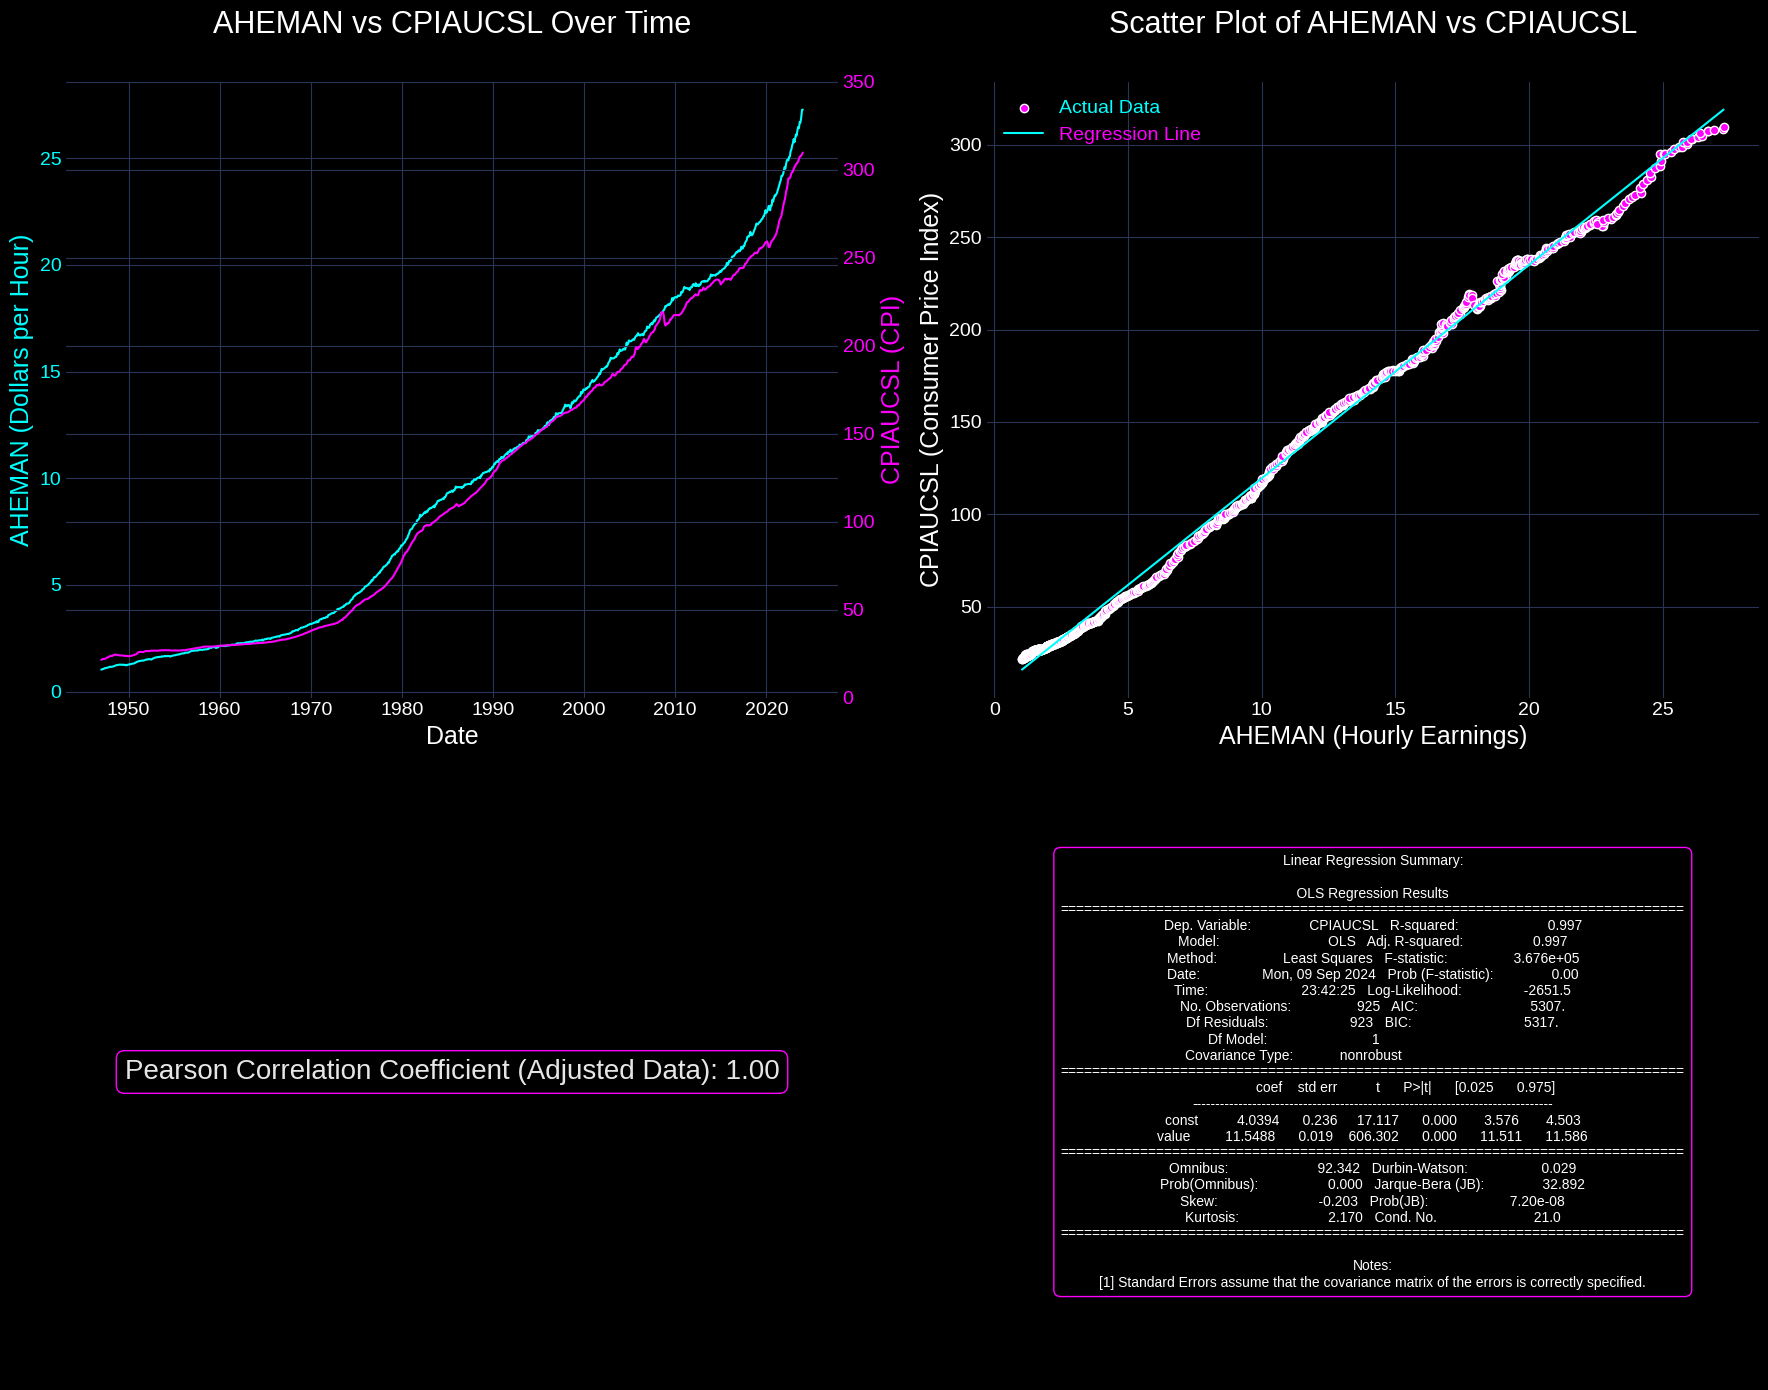

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from IPython.display import HTML

# Generate predictions from the regression model
y_pred = model.predict(X)

# Create a figure and axes for the dashboard
fig, axs = plt.subplots(2, 2, figsize=(18, 14), facecolor='#000000')
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot 1: Time Series - AHEMAN vs CPIAUCSL (Dual Axis)
ax1 = axs[0, 0]
ax1.plot(merged_data['date'], merged_data['value'], color='#00FFFF', label='AHEMAN (Hourly Earnings)', zorder=3)
ax1.set_xlabel('Date', fontsize=18, color='white')
ax1.set_ylabel('AHEMAN (Dollars per Hour)', fontsize=18, color='#00FFFF')
ax1.tick_params(axis='y', labelsize=14, colors='#00FFFF')
ax1.tick_params(axis='x', labelsize=14, colors='white')
ax1.set_facecolor('#000000')
ax1.spines['left'].set_color('#00FFFF')
ax1.spines['bottom'].set_color('white')

# Second y-axis for CPIAUCSL
ax2 = ax1.twinx()
ax2.plot(merged_data['date'], merged_data['CPIAUCSL'], color='#FF00FF', label='CPIAUCSL (Consumer Price Index)', zorder=3)
ax2.set_ylabel('CPIAUCSL (CPI)', fontsize=18, color='#FF00FF')
ax2.tick_params(axis='y', labelsize=14, colors='#FF00FF')
ax2.set_ylim(0, 350)  # Adjusted to fit the CPI data range
ax2.spines['right'].set_color('#FF00FF')

# Titles and layout adjustments
ax1.set_title('AHEMAN vs CPIAUCSL Over Time', fontsize=22, color='white', pad=35)
ax1.spines['top'].set_color('white')
ax2.spines['top'].set_color('white')

# Plot 2: Scatter Plot with Regression Line
axs[0, 1].scatter(merged_data['value'], merged_data['CPIAUCSL'], color='#FF00FF', label='Actual Data', edgecolor='white')
axs[0, 1].plot(merged_data['value'], y_pred, color='#00FFFF', label='Regression Line', zorder=4)
axs[0, 1].set_facecolor('#000000')
axs[0, 1].set_xlabel('AHEMAN (Hourly Earnings)', fontsize=18, color='white')
axs[0, 1].set_ylabel('CPIAUCSL (Consumer Price Index)', fontsize=18, color='white')
axs[0, 1].tick_params(axis='both', labelsize=14, colors='white')
axs[0, 1].spines['left'].set_color('white')
axs[0, 1].spines['bottom'].set_color('white')
axs[0, 1].spines['top'].set_color('white')
axs[0, 1].spines['right'].set_color('white')
axs[0, 1].set_title('Scatter Plot of AHEMAN vs CPIAUCSL', fontsize=22, color='white', pad=35)
axs[0, 1].legend(loc='upper left', fontsize=14, facecolor='#181818', edgecolor='white', labelcolor=['#00FFFF', '#FF00FF'])

# Plot 3: Pearson Correlation Coefficient
correlation = merged_data['value'].corr(merged_data['CPIAUCSL'])
axs[1, 0].text(0.5, 0.5, f'Pearson Correlation Coefficient (Adjusted Data): {correlation:.2f}', transform=axs[1, 0].transAxes, fontsize=20, verticalalignment='center', horizontalalignment='center', bbox=dict(boxstyle='round', facecolor='#000000', edgecolor='#FF00FF'))
axs[1, 0].axis('off')

# Plot 4: Linear Regression Summary
summary_text = model.summary().as_text()
axs[1, 1].text(0.5, 0.5, f'Linear Regression Summary:\n\n{summary_text}', transform=axs[1, 1].transAxes, fontsize=10, color='white', horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='#000000', edgecolor='#FF00FF', boxstyle='round,pad=0.5'))
axs[1, 1].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the complete dashboard
plt.show()
